In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import scipy as sp
from scipy import stats

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import sys
import gc
import copy
import glob

import tqdm
import itertools

import pymc

import sklearn as skl
from sklearn.utils import resample

In [2]:
def gen_raw_truncExpDist_sample(l,n,binLocs):
    lower=np.min(binLocs)
    upper=np.max(binLocs)
    probs=l*np.exp(-l*binLocs)/(
            np.exp(-lower*l)-np.exp(-upper*l))
    probs=probs/np.sum(probs)
    return np.random.choice(
        a=binLocs,
        p=probs,
        size=n)

def gen_synthetic_sim_sample(l,tSim,frameRate):
    tAcc=0
    lower=frameRate
    upper=tSim
    binLocs=np.arange(0,upper+lower,lower)
    distData=[]
    while tAcc<tSim:
        upper=tSim-tAcc
        binSet=binLocs[binLocs<=upper]
        #probs=l*np.exp(-l*binSet)/(np.exp(-lower*l)-np.exp(-upper*l))
        #probs=probs/np.sum(probs)
        sVal=np.clip(np.random.exponential(1./l,1),lower,upper)
        distData.append(sVal)
        tAcc=tAcc+sVal+frameRate
    return np.concatenate(distData)

In [3]:
def genTruncatedExpEquations(dataList,verbose=False,countsFirst=False):
    XhistList,aList,bList=dataList
    aList=np.array(aList)
    bList=np.array(bList)
    finiteB=np.nonzero(np.isfinite(bList))
    nFiniteB=np.nonzero(finiteB==False)
    Xsums=np.array([np.sum(Xhist[0]*Xhist[1]) for Xhist in XhistList])
    if countsFirst:
        Xcounts=np.array([np.sum(Xhist[0]) for Xhist in XhistList])
    else:
        Xcounts=np.array([np.sum(Xhist[1]) for Xhist in XhistList])
    if verbose:
        print 'truncation bounds:',
        print zip(aList,bList)
        print 'Histogram Mass Products:',
        print Xsums
        print 'Histogram Counts:',
        print Xcounts[finiteB]
        print 'finte upper bound list:',
        print finiteB
        print 'infinite upper bound list:',
        print nFiniteB
        print bList[finiteB]
    Nterm=lambda l: np.sum(Xcounts)/l
    finiteBterm=lambda l: np.sum(
        Xcounts[finiteB]* \
        (aList[finiteB]- \
             bList[finiteB]*np.exp((aList[finiteB]-bList[finiteB])*l))/ \
        (1-np.exp((aList[finiteB]-bList[finiteB])*l)))
    xSumTerm=np.sum(Xsums)
    if verbose:
        print 'combined sample mean: %.3f (lambda = %f)'%(
            xSumTerm/np.sum(Xcounts),np.sum(Xcounts)/xSumTerm)
    if np.sum(nFiniteB)>0:
        infBterm=lambda l: np.sum(Xcounts[nFiniteB]*aList[nFiniteB])
        optFun=lambda l: Nterm(l) + finiteBterm(l) + infBterm(l) - xSumTerm
    else:
        optFun=lambda l: Nterm(l) + finiteBterm(l) - xSumTerm
    return optFun

def fit_truncatedExp_to_dist(dataList,
                             verbose=False,
                             countsFirst=False,
                             returnFitData=False):
    fitFun=genTruncatedExpEquations(dataList,verbose,countsFirst)
    XhistList,aList,bList=dataList
    Xsums=np.array([np.sum(Xhist[0]*Xhist[1]) for Xhist in XhistList])
    if countsFirst:
        Xn=np.array([np.sum(Xhist[0]) for Xhist in XhistList])
    else:
        Xn=np.array([np.sum(Xhist[1]) for Xhist in XhistList])
    Xmean=1.*np.sum(Xsums)/np.sum(Xn)
    lFit=sp.optimize.root(fitFun,x0=1./Xmean)
    if returnFitData:
        return (lFit.x,lFit)
    else:
        return lFit.x

In [ ]:
simTime=1000
simFreq=.1
trueMean=25.0
trueLambda=1./trueMean

simBins=np.arange(0,simTime+simFreq,simFreq)
simLocs=(simBins[1:]+simBins[:-1])/2.

binWidth=1.0
binLocs=np.arange(0,simTime+binWidth,binWidth)

binCenters=(binLocs[1:]+binLocs[:-1])/2.

testSimData=gen_synthetic_sim_sample(trueLambda,simTime,simFreq)

testSimDist=np.histogram(a=testSimData,bins=binLocs)

print "true mean: %f (true lambda = %f)"%(trueMean,trueLambda)
print 'Raw sim mean: %f (Raw sim lambda = %f)'%(np.mean(testSimData),1/np.mean(testSimData))
testSimMean=1.*np.sum(binCenters*testSimDist[0])/np.sum(testSimDist[0])
print "Re-binned sim mean: %f (est. lambda = %f)"%(
    testSimMean,1./testSimMean)
#plt.hist(testSimData,bins=simBins)
simHist=np.histogram(testSimData,bins=simBins)
simNZinds=np.nonzero(simHist[0])
plt.scatter(simLocs[simNZinds],simHist[0][simNZinds],c='r')
plt.title('Histogram for Raw Simulation Data')
plt.show()

#plt.hist(binCenters,weights=testSimDist[0],alpha=.5)
plt.scatter(binLocs[np.nonzero(testSimDist[0])],
            testSimDist[0][np.nonzero(testSimDist[0])],c='r')
plt.title('Rebinned Sim Data')
plt.show()

nzInds=np.nonzero(testSimDist[0]>0)
nzIndMax=np.max(nzInds[0])
xMax=binCenters[nzIndMax]

nonTrunc_l=1./(np.sum(testSimDist[0]*binCenters)/np.sum(testSimDist[0]))
print 'non-truncated lambda: %f (non-truncated mean = %f)'%(nonTrunc_l,1./nonTrunc_l)
(trunc_l,trunc_fit)=fit_truncatedExp_to_dist(
    ([testSimDist[0],binCenters],
     [simFreq],[simTime]),
    countsFirst=True,returnFitData=True)
print 'fitting info for truncated exponential:'
print trunc_fit

print 'truncated lambda: %f (truncated mean = %f)'%(trunc_l,1./trunc_l)

simProbs=1.*testSimDist[0][nzInds]/np.sum(testSimDist[0])
print simProbs
#plt.hist(testSimData)
plt.scatter(binCenters[nzInds],
            simProbs,alpha=.5,
            label='Sim. Distribution')
plt.plot(binCenters[nzInds],
         nonTrunc_l*np.exp(-nonTrunc_l*binCenters[nzInds]),
         label='Non-Truncated Exp. Fit')
plt.legend()
plt.show()

plt.scatter(binCenters[nzInds],
            simProbs,alpha=.5,
            label='Sim. Distribution')
plt.plot(binCenters[nzInds],
         trunc_l*np.exp(-trunc_l*binCenters[nzInds]),
         label='Truncated Exp. Fit')
plt.legend()
plt.show()

In [ ]:
@interact_manual
def testSims(nSims=(3,100,1),
             frameRate=(.01,1,.01),
             binWidth=(1,100,1),
             trueMean=(1,1000,1),
             simLen=(1000,10000,100)):
    rawSimMeans=[]
    rebinnedSimMeans=[]
    correctedSimMeans=[]
    binSet=np.arange(0,simLen,binWidth)
    binLocs=(binSet[1:]+binSet[:-1])/2.
    simSampleSizes=[]
    for iSim in tqdm.tqdm_notebook(np.arange(nSims)):
        rawSimData=gen_synthetic_sim_sample(frameRate=frameRate,l=1./trueMean,tSim=simLen)
        simSampleSizes.append(len(rawSimData))
        rawSimMeans.append(np.mean(rawSimData))
        simHist=np.histogram(rawSimData,bins=binSet)
        rebinnedSimMeans.append(np.sum(simHist[0]*binLocs)/np.sum(simHist[0]))
        trunc_l=fit_truncatedExp_to_dist(
            ([simHist[0],binLocs],
             [binWidth],[simTime]),
            countsFirst=True)[0]
        correctedSimMeans.append(1./trunc_l)
    fig,axs=plt.subplots(1,3)
    fig.set_figwidth(12)
    fig.set_figheight(4)
    ax=axs.flat[0]
    ax.hist(rawSimMeans)
    ax.axvline(x=np.mean(rawSimMeans),c='r')
    ax.set_title('Raw Sim Means (mean = %f)'%np.mean(rawSimMeans))
    ax=axs.flat[1]
    ax.hist(rebinnedSimMeans)
    ax.axvline(x=np.mean(rebinnedSimMeans),c='r')
    ax.set_title('Re-binned Sim Means (mean = %f)'%np.mean(rebinnedSimMeans))
    ax=axs.flat[2]
    ax.hist(correctedSimMeans)
    ax.axvline(x=np.mean(correctedSimMeans),c='r')
    ax.set_title('Corrected Sim Means (mean = %f)'%np.mean(correctedSimMeans))
    plt.tight_layout()
    plt.show()
    
    plt.hist(simSampleSizes)
    plt.title('Sample Size Distribution')
    plt.show()

# Bootstrapping

## Generate synthetic simulation data

Run synthetic exponential sampling simulations over a range of different exponential means
Run 4 Simulation replicas for each simulated mean

Each simulation / replica is run using the same simulation length and frame rate.
This allows us to examine effectiveness for estimating means relative to a fixed frame rate and simulation time

In [4]:
simLen=2000.
frameRate=.6
binWidth=1.0
nReps=4
simMeans=10**np.linspace(np.log10(frameRate/2),np.log10(simLen*2),21)
#print simMeans

histBins=np.arange(0,simLen,binWidth)
histCenters=(histBins[:-1]+histBins[1:])/2.
print histCenters
simDataFrames=[]
for iMean,trueMean in enumerate(simMeans):
    print 'Generating data for Sim_%03g (Mean=%8.3f):'%(iMean,trueMean),
    for iRep in np.arange(nReps):
        print 'Rep_%02g'%iRep,
        rawSimData=gen_synthetic_sim_sample(frameRate=frameRate,l=1./trueMean,tSim=simLen)
        tempHist=np.histogram(rawSimData,histBins)
        nzInds=np.nonzero(tempHist[0])
        simHist=(histCenters[nzInds],tempHist[0][nzInds])
        nRows=len(simHist[0])
        tempFrame=pd.DataFrame({
            'SimID':['Sim_%03g'%iMean]*nRows,
            'Rep':['Rep_%02g'%iRep]*nRows,
            'WaitTime':simHist[0],
            'Count':simHist[1],
            'TrueMean':[trueMean]*nRows},
            columns=['SimID','Rep','WaitTime','Count','TrueMean'])
        simDataFrames.append(tempFrame)
    print ''
simDataFrame=pd.concat(simDataFrames)
del(simDataFrames)
gc.collect()
simDataFrame.head()

[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.9965e+03 1.9975e+03 1.9985e+03]
Generating data for Sim_000 (Mean=   0.300): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_001 (Mean=   0.482): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_002 (Mean=   0.776): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_003 (Mean=   1.247): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_004 (Mean=   2.005): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_005 (Mean=   3.224): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_006 (Mean=   5.183): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_007 (Mean=   8.334): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_008 (Mean=  13.400): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_009 (Mean=  21.545): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_010 (Mean=  34.641): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_011 (Mean=  55.698): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_012 (Mean=  89.5

,SimID,Rep,WaitTime,Count,TrueMean
0,Sim_000,Rep_00,0.5,1538,0.3
1,Sim_000,Rep_00,1.5,64,0.3
2,Sim_000,Rep_00,2.5,2,0.3
0,Sim_000,Rep_01,0.5,1558,0.3
1,Sim_000,Rep_01,1.5,52,0.3


## Investigate correlation and relative error between estimated mean and true mean

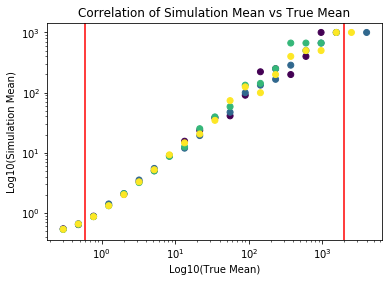

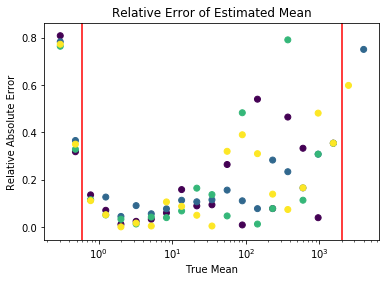

,SimID,Rep,Count,Sum_Xi,TrueMean,SimMean,RelAbsErr
0,Sim_000,Rep_00,1604,870.0,0.300000,0.542394,0.807980
1,Sim_000,Rep_01,1612,862.0,0.300000,0.534739,0.782465
2,Sim_000,Rep_02,1619,856.5,0.300000,0.529030,0.763434
3,Sim_000,Rep_03,1615,858.5,0.300000,0.531579,0.771930
4,Sim_001,Rep_00,1504,956.0,0.482357,0.635638,0.317777


In [5]:
simDataFrame['Sum_Xi']=simDataFrame.WaitTime*simDataFrame.Count
countDat=simDataFrame.groupby(['SimID','Rep']).agg({
    'Count':np.sum,
    'Sum_Xi':np.sum,
    'TrueMean':np.mean}).reset_index()
countDat['SimMean']=countDat.Sum_Xi/countDat.Count
countDat['RelAbsErr']=(countDat.TrueMean-countDat.SimMean).abs()/countDat.TrueMean

plt.scatter(countDat.TrueMean,countDat.SimMean,
            c=countDat.Rep.map(lambda x: int(x.split('_')[1])))
plt.axvline(frameRate,c='r')
plt.axvline(simLen,c='r')
plt.title('Correlation of Simulation Mean vs True Mean')
plt.xlabel('Log10(True Mean)')
plt.ylabel('Log10(Simulation Mean)')
plt.loglog(base=10)
plt.show()

plt.scatter(countDat.TrueMean,countDat.RelAbsErr,
            c=countDat.Rep.map(lambda x: int(x.split('_')[1])))

plt.axvline(frameRate,c='r')
plt.axvline(simLen,c='r')
plt.title('Relative Error of Estimated Mean')
plt.xlabel('True Mean')
plt.ylabel('Relative Absolute Error')
plt.xscale('log',basex=10)
#plt.yscale('log',basey=10)
#plt.loglog(base=10)
plt.show()

countDat.head()

In [ ]:
simDataFrame.head()

In [6]:
def sample_histogram(histogramData,n=1000,countsFirst=False,verbose=False):
    if countsFirst:
        xVals=np.ndarray.flatten(np.array(histogramData[1]))
        xCounts=np.ndarray.flatten(np.array(histogramData[0]))
    else:
        xVals=np.ndarray.flatten(np.array(histogramData[0]))
        xCounts=np.ndarray.flatten(np.array(histogramData[1]))
    if verbose:
        print 'xVals:',
        print xVals
        print 'xCounts:',
        print xCounts
    xProbs=1.*xCounts/np.sum(xCounts)
    return np.random.choice(xVals,p=xProbs,size=n)

def bootstrap_histogram(histogramData,sampleSize,nSamples,
                        countsFirst=False,verbose=False):
    return [sample_histogram(
                histogramData,sampleSize,countsFirst,verbose) \
            for iSample in np.arange(nSamples)]

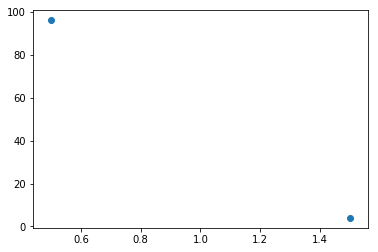

In [7]:
testSample=sample_histogram(
    (np.array(simDataFrame[(simDataFrame.SimID=='Sim_000') & \
                          (simDataFrame.Rep=='Rep_00')
                         ][['WaitTime']]),
    np.array(simDataFrame[(simDataFrame.SimID=='Sim_000') & \
                          (simDataFrame.Rep=='Rep_00')
                         ][['Count']])),
    n=100,countsFirst=False,verbose=False)
testDist=np.unique(testSample,return_counts=True)
plt.scatter(*testDist)
plt.show()

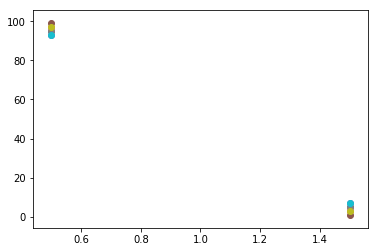

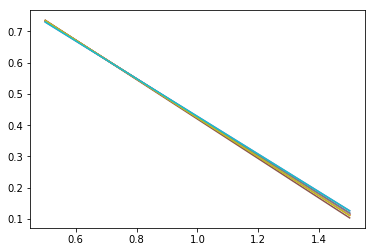

[0.55, 0.53, 0.54, 0.54, 0.57, 0.51, 0.54, 0.55, 0.53, 0.57]
0.543
0.001734935157289745


In [8]:
bootstrapSamples=bootstrap_histogram(
    (np.array(simDataFrame[(simDataFrame.SimID=='Sim_000') & \
                          (simDataFrame.Rep=='Rep_00')
                         ][['WaitTime']]),
    np.array(simDataFrame[(simDataFrame.SimID=='Sim_000') & \
                          (simDataFrame.Rep=='Rep_00')
                         ][['Count']])),
    sampleSize=100,nSamples=10,countsFirst=False,verbose=False)
testDists=[np.unique(testSample,return_counts=True) for testSample in bootstrapSamples]
for testDist in testDists:
    plt.scatter(*testDist)
    #plt.loglog()
plt.show()
distMeans=[]
for testDist in testDists:
    distMean=np.sum(1.*testDist[0]*testDist[1])/np.sum(testDist[1])
    distMeans.append(distMean)
    plt.plot(testDist[0],
             1./distMean*np.exp(-testDist[0]/distMean))
    #plt.loglog()
plt.show()
print distMeans
print np.mean(distMeans)
print np.std(distMeans)/len(distMeans)

In [ ]:
simDataFrame.head()

  3%|▎         | 2/77 [00:00<00:05, 13.20it/s]

generating bootstrap samples


100%|██████████| 77/77 [00:00<00:00, 942.13it/s]


computing bootstrap sample means
SimID    Rep   
Sim_000  Rep_00       0.542394
         Rep_01       0.534739
         Rep_02       0.529030
         Rep_03       0.531579
Sim_001  Rep_00       0.635638
         Rep_01       0.658570
         Rep_02       0.640761
         Rep_03       0.651108
Sim_002  Rep_00       0.880730
         Rep_01       0.864479
         Rep_02       0.864688
         Rep_03       0.861751
Sim_003  Rep_00       1.334817
         Rep_01       1.404517
         Rep_02       1.310226
         Rep_03       1.311265
Sim_004  Rep_00       2.027591
         Rep_01       2.094223
         Rep_02       2.070652
         Rep_03       2.005945
Sim_005  Rep_00       3.300391
         Rep_01       3.514493
         Rep_02       3.183112
         Rep_03       3.276471
Sim_006  Rep_00       5.014124
         Rep_01       5.472561
         Rep_02       4.966480
         Rep_03       5.204348
Sim_007  Rep_00       8.830189
         Rep_01       8.973684
                     

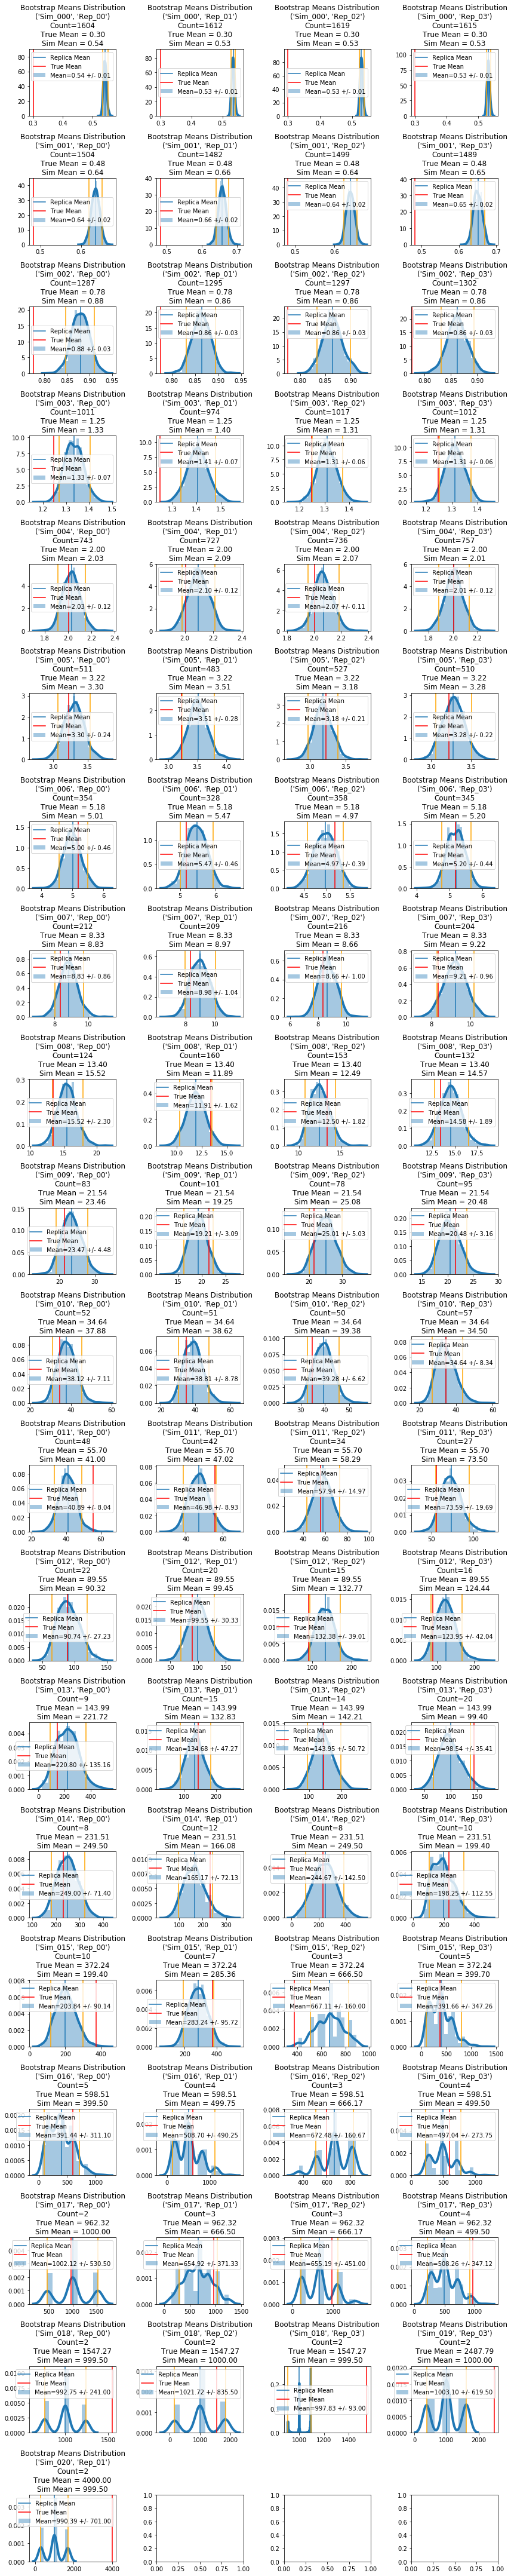

In [18]:
nBootSamples=1000
bootSampleSize=16

bootResultFrames=[]

keyCols=['SimID','Rep']

xCol='WaitTime'
countCol='Count'

testDat=simDataFrame #[simDataFrame.Rep=='Rep_01']
#trueMean=testDat.TrueMean.mean()
testGroups=testDat.groupby(keyCols)

#testGroups.apply(lambda grp: bootstrap_histogram(
#    histogramData=(grp[xCol],grp[countCol]),
#    sampleSize=np.min(bootSampleSize,grp[xCol].count()),
#    nSamples=nBootSamples))

tqdm.tqdm.pandas(tqdm.tqdm_notebook())
#use bootstrapping to generate confidence intervals of the mean
#for each replica of each synthetic test simulation
print "generating bootstrap samples"
tempSummary=testGroups.progress_apply(
    #describe distribution of means of bootstrap samplings
    lambda grp: 
        #pd.Series(
        #compute mean of bootstrap samplings
        map(lambda x: np.mean(x),
            #Create boostrap samplings from group histogram
            bootstrap_histogram(
              histogramData=(grp[xCol],grp[countCol]),
              sampleSize=grp[countCol].sum(),
              nSamples=nBootSamples)
           )
    #).describe()[['count','mean','std']]
)
tempSummary

print 'computing bootstrap sample means'
groupMeans=testGroups.progress_apply(
    lambda grp: np.sum(grp[xCol]*grp[countCol]/np.sum(grp[countCol])))
print groupMeans
groupCounts=testGroups.Count.sum()

trueMeans=testGroups.TrueMean.mean()

pBoot=5

nCols=4 #int(np.sqrt(len(tempSummary)))
nRows=int(np.ceil(1.*len(tempSummary)/nCols))

fig,axs=plt.subplots(nRows,nCols)
figWidth=12
hPad=0.0 #1.0
fig.set_figwidth(figWidth)
fig.set_figheight((figWidth-hPad)/nCols*nRows*1.)

print 'generating bootstrap results plots'
for iGrp,grp in tqdm.tqdm_notebook(enumerate(tempSummary)):
    ax=axs.flat[iGrp]
    #print '[%s Count=%g]'%(
    #    tempSummary.index[iGrp],groupCounts[iGrp]),
    trueMean=trueMeans[iGrp]
    eLower=np.percentile(grp,q=pBoot)
    eUpper=np.percentile(grp,q=(100-pBoot))
    sns.distplot(grp, hist=True, kde=True,
                 #color = 'darkblue',
                 #hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4},
                 label='Mean=%.2f +/- %.2f'%(
                     np.mean(grp),
                     (eUpper-eLower)/2.),
                 ax=ax)
    ax.axvline(eLower,c='orange')
    ax.axvline(eUpper,c='orange')
    ax.axvline(groupMeans[iGrp],label='Replica Mean')
    
    #plt.hist(grp,alpha=.5,density=True,
    #         label='%s: Mean=%.2f +/- %.2f'%(
    #             tempSummary.index[iGrp],
    #             np.mean(grp),
    #             2*np.std(grp)/np.sqrt(len(grp))))
    ax.axvline(trueMean,c='r',label='True Mean')
    ax.legend()
    ax.set_title('Bootstrap Means Distribution\n%s\nCount=%g\nTrue Mean = %.2f\nSim Mean = %.2f'%(
        tempSummary.index[iGrp],groupCounts[iGrp],trueMean,groupMeans[iGrp]))
plt.tight_layout()
plt.show()

In [19]:
tempSummary.head()

SimID    Rep   
Sim_000  Rep_00    [0.5380299251870324, 0.5405236907730673, 0.544...
         Rep_01    [0.5366004962779156, 0.5384615384615384, 0.535...
         Rep_02    [0.5277949351451513, 0.535206917850525, 0.5284...
         Rep_03    [0.5278637770897833, 0.5297213622291022, 0.534...
Sim_001  Rep_00    [0.6436170212765957, 0.6343085106382979, 0.636...
dtype: object

In [50]:
bootSummary=tempSummary.apply(lambda x: pd.Series(x).describe())
bootSummary['TrueMean']=trueMeans
bootSummary['N']=groupCounts
qcut=.95
quKwds={'q':qcut}
qlKwds={'q':1.00-qcut}
bootSummary['CI_Upper']=tempSummary.apply(np.quantile,**quKwds)
bootSummary['CI_Lower']=tempSummary.apply(np.quantile,**qlKwds)
bootSummary.head()

count      mean       std       min       25%       50%  \
SimID   Rep                                                                
Sim_000 Rep_00  1000.0  0.542443  0.005387  0.523067  0.538653  0.542394   
        Rep_01  1000.0  0.534542  0.004689  0.521712  0.531017  0.534739   
        Rep_02  1000.0  0.529191  0.004392  0.517295  0.525942  0.529030   
        Rep_03  1000.0  0.531529  0.004333  0.519195  0.528483  0.531579   
Sim_001 Rep_00  1000.0  0.635868  0.010129  0.601729  0.628989  0.635638   

                     75%       max  TrueMean     N  CI_Upper  CI_Lower  
SimID   Rep                                                             
Sim_000 Rep_00  0.545511  0.562344  0.300000  1604  0.551746  0.534289  
        Rep_01  0.537841  0.551489  0.300000  1612  0.542184  0.527295  
        Rep_02  0.532119  0.542619  0.300000  1619  0.537060  0.522236  
        Rep_03  0.534056  0.546440  0.300000  1615  0.539009  0.524737  
Sim_001 Rep_00  0.642952  0.668883  0.482357  1504  0.652261  0.619648

In [51]:
plotData=bootSummary.reset_index()
plotData.head()

,SimID,Rep,count,mean,std,min,25%,50%,75%,max,TrueMean,N,CI_Upper,CI_Lower
0,Sim_000,Rep_00,1000.0,0.542443,0.005387,0.523067,0.538653,0.542394,0.545511,0.562344,0.300000,1604,0.551746,0.534289
1,Sim_000,Rep_01,1000.0,0.534542,0.004689,0.521712,0.531017,0.534739,0.537841,0.551489,0.300000,1612,0.542184,0.527295
2,Sim_000,Rep_02,1000.0,0.529191,0.004392,0.517295,0.525942,0.529030,0.532119,0.542619,0.300000,1619,0.537060,0.522236
3,Sim_000,Rep_03,1000.0,0.531529,0.004333,0.519195,0.528483,0.531579,0.534056,0.546440,0.300000,1615,0.539009,0.524737
4,Sim_001,Rep_00,1000.0,0.635868,0.010129,0.601729,0.628989,0.635638,0.642952,0.668883,0.482357,1504,0.652261,0.619648


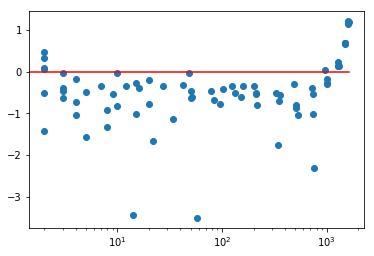

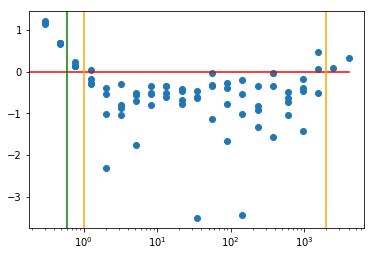

In [68]:
plt.scatter(plotData['N'],
            np.log10(np.abs(plotData['TrueMean']-plotData['mean'])/(plotData['CI_Upper']-plotData['CI_Lower'])))
plt.plot([0,np.max(plotData['N'])],
         [0,0],c='r')
plt.xscale('log')
plt.show()

plt.scatter(plotData['TrueMean'],
            np.log10(np.abs(plotData['TrueMean']-plotData['mean'])/(plotData['CI_Upper']-plotData['CI_Lower'])))
plt.plot([0,np.max(plotData['TrueMean'])],
         [0,0],c='r')
plt.axvline(frameRate,c='g')
plt.axvline(binWidth,c='orange')
plt.axvline(simLen,c='orange')
plt.xscale('log')
plt.show()

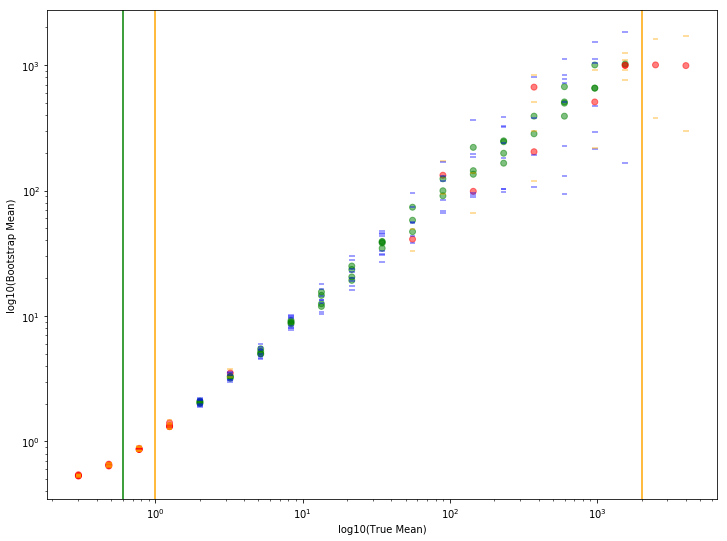

In [86]:
plt.figure(figsize=(12,9))
plt.scatter(plotData['TrueMean'],
            plotData['mean'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'green' if (x[0]>x[1])&(x[0]<x[2]) else 'red',
                axis=1),
            alpha=.5)
plt.scatter(plotData['TrueMean'],
            plotData['CI_Lower'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
plt.scatter(plotData['TrueMean'],
            plotData['CI_Upper'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
plt.loglog()
plt.axvline(frameRate,c='g')
plt.axvline(binWidth,c='orange')
plt.axvline(simLen,c='orange')
plt.xlabel('log10(True Mean)')
plt.ylabel('log10(Bootstrap Mean)')
plt.show()

In [84]:
simMeans

array([3.00000000e-01, 4.82356563e-01, 7.75559511e-01, 1.24698740e+00,
       2.00497519e+00, 3.22370980e+00, 5.18325859e+00, 8.33392931e+00,
       1.33997517e+01, 2.15448605e+01, 3.46410162e+01, 5.56977382e+01,
       8.95538985e+01, 1.43989702e+02, 2.31514593e+02, 3.72241944e+02,
       5.98511148e+02, 9.62319266e+02, 1.54727004e+03, 2.48778620e+03,
       4.00000000e+03])

In [91]:
10**.1

1.2589254117941673

In [93]:
10**3

1000

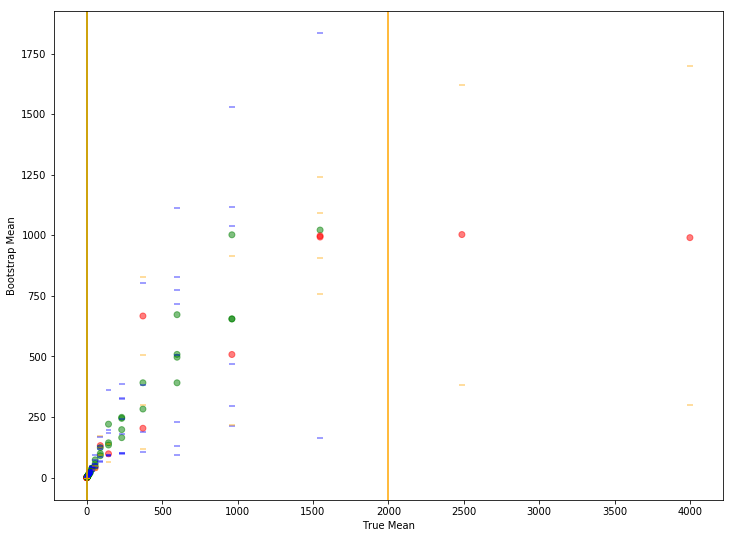

In [94]:
plt.figure(figsize=(12,9))
plt.scatter(plotData['TrueMean'],
            plotData['mean'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'green' if (x[0]>x[1])&(x[0]<x[2]) else 'red',
                axis=1),
            alpha=.5)
plt.scatter(plotData['TrueMean'],
            plotData['CI_Lower'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
plt.scatter(plotData['TrueMean'],
            plotData['CI_Upper'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
#plt.loglog()
plt.axvline(frameRate,c='g')
plt.axvline(binWidth,c='orange')
plt.axvline(simLen,c='orange')
plt.xlabel('True Mean')
plt.ylabel('Bootstrap Mean')
plt.show()

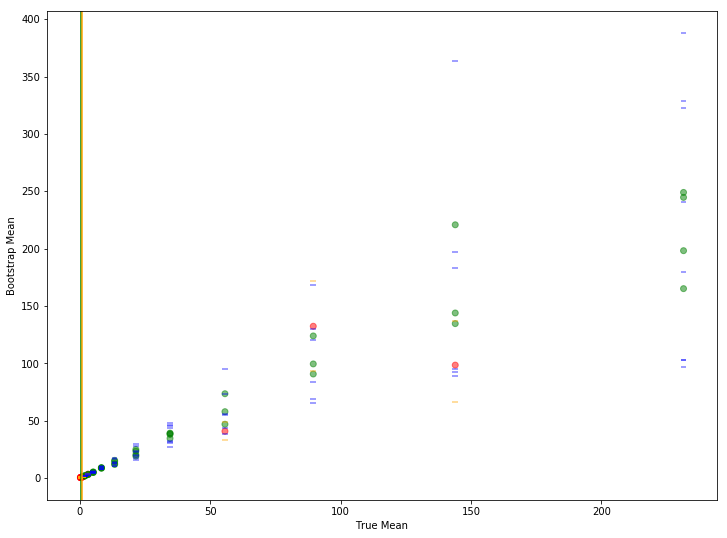

In [98]:
plotData=bootSummary[bootSummary.TrueMean<250].reset_index()
plt.figure(figsize=(12,9))
plt.scatter(plotData['TrueMean'],
            plotData['mean'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'green' if (x[0]>x[1])&(x[0]<x[2]) else 'red',
                axis=1),
            alpha=.5)
plt.scatter(plotData['TrueMean'],
            plotData['CI_Lower'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
plt.scatter(plotData['TrueMean'],
            plotData['CI_Upper'],
            c=plotData[['TrueMean','CI_Lower','CI_Upper']].apply(
                lambda x: 'blue' if (x[0]>x[1])&(x[0]<x[2]) else 'orange',
                axis=1),
            alpha=.5,s=32,marker='_')
#plt.loglog()
plt.axvline(frameRate,c='g')
plt.axvline(binWidth,c='orange')
#plt.axvline(simLen,c='orange')
plt.xlabel('True Mean')
plt.ylabel('Bootstrap Mean')
plt.show()